In [1]:
from qiskit import *
# Qiskit module
from qiskit import QuantumCircuit
import qiskit.circuit.library as circuit_library
import qiskit.quantum_info as qi
import qiskit.ignis.mitigation as mit

# Qiskit tools for running and monitoring jobs
from qiskit import execute
from qiskit.tools.monitor import job_monitor

from qiskit.tools.visualization import *
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.special import erf
# Other imports
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
# Qiskit for pulse 
from qiskit import pulse

from qiskit import *
from qiskit.pulse import Play, Schedule, DriveChannel, ControlChannel, Waveform, ShiftPhase
from qiskit.pulse.library import drag, GaussianSquare, Drag
from qiskit.visualization import SchedStyle
from qiskit.providers.aer import AerSimulator

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

from qiskit.circuit.gate import Gate

# Fake backend
#from qiskit.test.mock import FakeAthens

from scipy import integrate


In [2]:
def h_Z(qc,h,dt,L):
    """
    hi
    
    """
    
    #q0=qubits_list[0]
    
    #q4=qubits_list[4]
    
    for i in range(L):
        if i==0 or i==L-1:
            qc.rz(h*dt,i)
        else:
            qc.rz(2*h*dt,i)
        
        
def ZZ(qc,V,dt,L): # nearest neighbor coupling
    
    for i in range(1,L-1,2):
        
        qc.rzz(-2*V*dt,i,i+1)
        
    for i in range(0,L-1,2):
        
        qc.rzz(-2*V*dt,i,i+1)
    
def X_Rabi(qc,Omega,dt,L): # Rabi coupling
    
    for i in range(L):
        
        qc.rx(2*Omega*dt,i)

In [3]:
def Trotter_circuit_5_site_no_custom(h,Omega,V,T,n,L):
    
    """
    hi
    """
    Trotter_cirs = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(L,L)#, name=str(i)+'Trots')
        
        ### Initial state setting
        
        for u in range(1,L,2):
        
        #for u in range(5):
            
            #Trotter_circuit.u1(np.pi,u)
            
            Trotter_circuit.x(u)
            
            #Trotter_circuit.h(u)
            
            
        
        #Trotter_circuit.x(1)
        
        #Trotter_circuit.x(3)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            
            X_Rabi(Trotter_circuit,Omega,dt,L) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt,L) # Z field 
            
            #Trotter_circuit.barrier()
            
            ZZ(Trotter_circuit,V,dt,L) # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
    
        j=0
        
        for i in range(L):
            
            Trotter_circuit.measure(i,j)
            
            j+=1
        
        #Trotter_circuit = transpile(Trotter_circuit, backend) # compile into specific backend
        
        Trotter_cirs.append(Trotter_circuit)
        
        #Trotter_gates.append(Trotter_circuit.to_gate(label=str(i)+'Trots'))
        
        
    return Trotter_cirs
    

In [4]:
L=12

Omega = 0.24

V = -1

h = 2*V

T = 40 #1.5 # Total time

TT=T*2

n = 40 #20

NN=n

#qubit_list = [0,1,3,5,4]

site=2

#Trotter_circuit_no_custom = ZZ_Auto_Correlation_circ(h,Omega,V,T,n,site)

Trotter_circuit_no_custom = Trotter_circuit_5_site_no_custom(h,Omega,V,T,n,L)

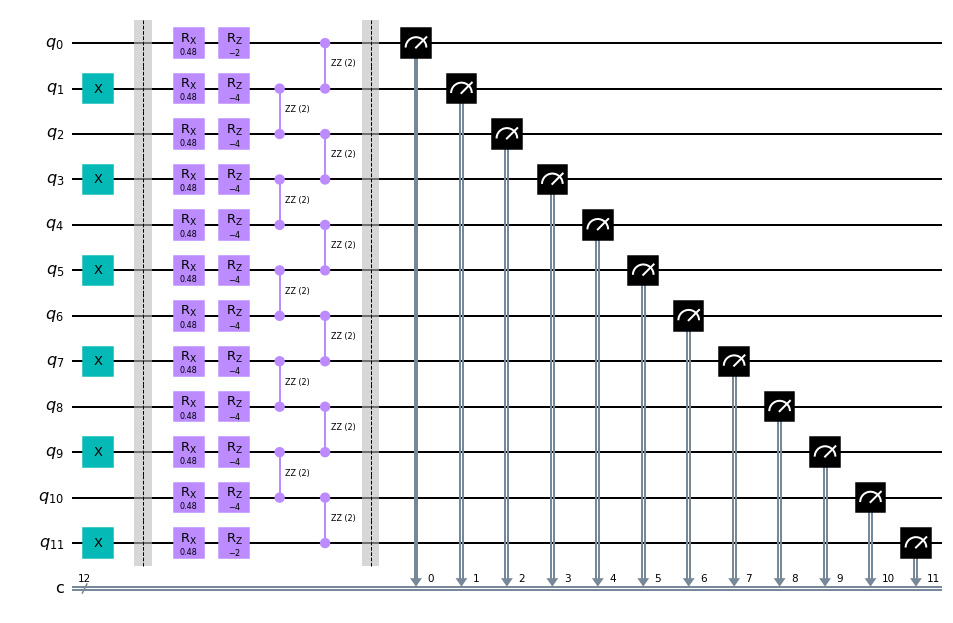

In [5]:
Trotter_circuit_no_custom[1].draw('mpl')

In [6]:
shots = 8192

il = [i for i in range(L)]

Trotter_circuit_sim = execute(Trotter_circuit_no_custom, Aer.get_backend('qasm_simulator'), shots=shots, initial_layout=il)

#Trotter_result = execute(Trotter_circuit, backend, shots=shots, initial_layout=il)

#Trotter_result_no_custom = execute(Trotter_circuit_no_custom, backend, shots=shots, initial_layout=il)

#Trotter_result_DD = execute(Trotter_circuit_DD, backend, shots=shots, initial_layout=il)

#Trotter_mit  = execute(meas_calibs, backend, shots=shots, initial_layout=il)

#print('Job IDs: \n calibration circuit: {}\n Trotter circuit: {}'.format(Trotter_mit.job_id(), Trotter_result.job_id()))

In [7]:


results = Trotter_circuit_sim.result()


In [8]:
#cal_results = Trotter_mit.result()

In [9]:
#meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=qubit_list, circlabel='mcal')

In [10]:
result_sim=Trotter_circuit_sim.result()

In [11]:
Sz_sim = []
for i in range(NN):
    tot_sim=np.zeros(L)
    Result_sim = result_sim.get_counts(i) 
    for j in range(2**L):
        n=2**L
        if j in Result_sim.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_sim+=(2*np.array(c.join(a).split()).astype(int)-1)*Result_sim.int_outcomes()[j] 
    Sz_sim.append(tot_sim/8192)
Sz_sim=np.array(Sz_sim)

 # Exact Diagonalization

In [12]:

import scipy.linalg as la

def flip(n,i,L): 
    # Flip the i site spin in n-state with system size L
    ii=2**(L-i-1)
    nn=2**L
    if int(bin(n+nn)[3:][i])==1:
        return binaryToDecimal(int(bin(n-ii)[2:]))
    if int(bin(n+nn)[3:][i])==0:
        return binaryToDecimal(int(bin(n+ii)[2:]))


def binaryToDecimal(binary): 
    # change the binary number into decimal number
    binary1 = binary 
    decimal, i, n = 0, 0, 0
    while(binary != 0): 
        dec = binary % 10
        decimal = decimal + dec * pow(2, i) 
        binary = binary//10
        i += 1
    return decimal  

def spin_x(i,L):
    n=2**L
    X=np.zeros((n,n))
    for j in range(n):
        X[j,flip(j,i,L)]=1
    return X

def spin_y(i,L):
    n=2**L
    Y=np.zeros((n,n),dtype=complex)
    for j in range(n):
        Y[j,flip(j,i,L)]=1j*(-1)**(int(bin(j+n)[3:][i]))
    return Y

def spin_z(i,L):
    n=2**L
    Z=np.zeros((n,n))
    #a=2**L-1
    for j in range(n):
        Z[j,j]=2*int(bin(j+n)[2:][::-1][i])-1
    return Z

In [13]:
L=12

Omega = 0.24 #.6 #20 #0.48

 #2*2

V = 1 #1*2

h = 2*V


H0=0
for i in range(L):
    H0=H0+Omega*spin_x(i,L) # Rabi coupling
    
H1=0
H1=H1+h*spin_z(0,L)/2
H1=H1+h*spin_z(L-1,L)/2
for i in range(L-2):
    H1=H1+h*spin_z(i+1,L) 


V0=0
for i in range(L-1):
    n_f=spin_z((i)%L,L)
    n_b=spin_z((i+1)%L,L)
    V0=V0+V*np.dot(n_f,n_b)


H=H0+H1+V0

In [14]:
M=H
vals, vecs = la.eigh(M)

inds=np.argsort(vals)
e=vals[inds]
v=vecs[:,inds]

In [15]:
Nt=40-1
T=40#*2 #1.5
dt=T/Nt

A=np.eye(len(e))*e

U=np.dot(v,np.dot(np.exp(-1j*A*dt)*np.eye(len(e)),np.conj(np.transpose(v))))

f = 1365

wavefunc=np.zeros((len(e),Nt+1),dtype=complex)
n=np.zeros(len(e),dtype=complex)
#n=np.ones(len(e),dtype=complex)
#n=[np.sqrt(1/(2**L)) for i in range(2**L)]
n[f]=1
#n=n*(1/(np.sqrt(2**5)))
wavefunc[:,0]=n
for i in range(Nt):
    wavefunc[:,i+1]=np.dot(U,wavefunc[:,i])

In [16]:
def Zi_t_p(tf,dt,i):
  
  
    #Nt=tf/dt
    #Nt=int(Nt)

    Zt=spin_z(i,L)
    Zt1=[np.real(np.dot(np.conjugate(wavefunc[:,i]),np.dot(Zt,wavefunc[:,i]))) for i in range(Nt+1)]
    Zt1=np.stack(Zt1,axis=0)
    return Zt1

In [17]:
def Xi_t_p(tf,dt,i):
  
  
    #Nt=tf/dt
    #Nt=int(Nt)

    Zt=spin_x(i,L)
    Zt1=[np.real(np.dot(np.conjugate(wavefunc[:,i]),np.dot(Zt,wavefunc[:,i]))) for i in range(Nt+1)]
    Zt1=np.stack(Zt1,axis=0)
    return Zt1

In [19]:
Zi=np.zeros((L,Nt+1))

for i in range(L):
  
    Zi[i,:]=np.real(Zi_t_p(T,dt,i))

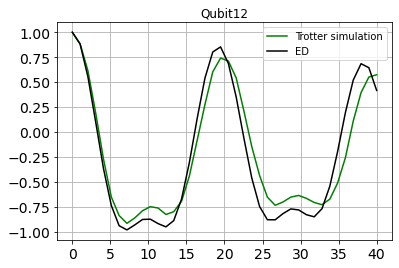

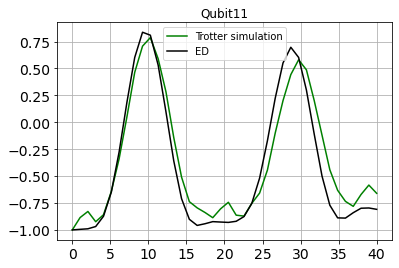

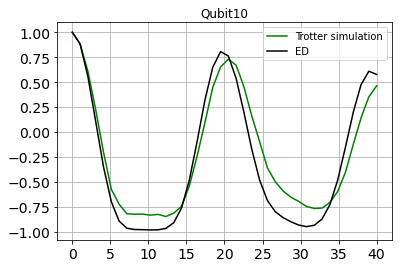

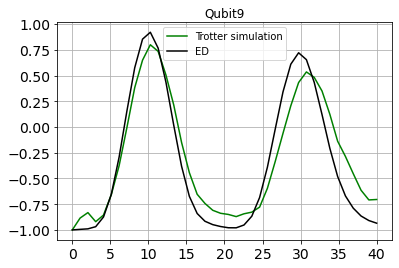

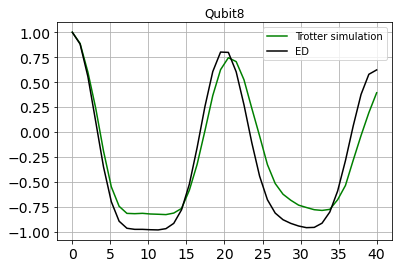

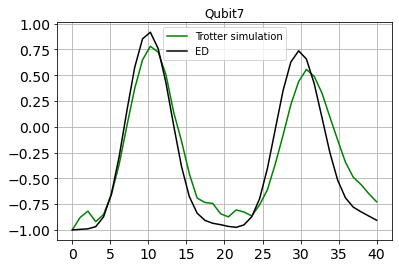

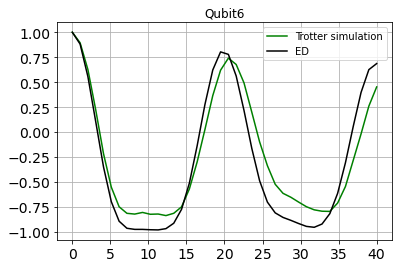

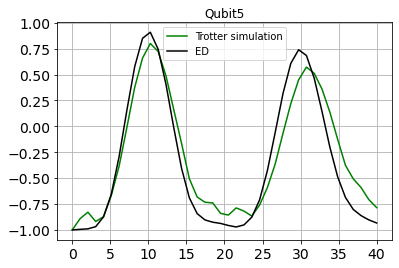

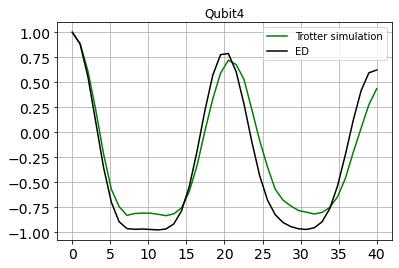

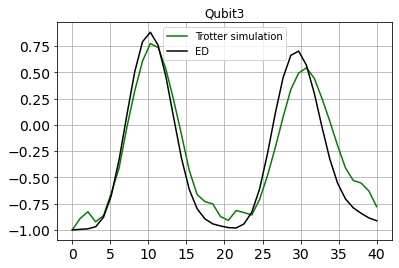

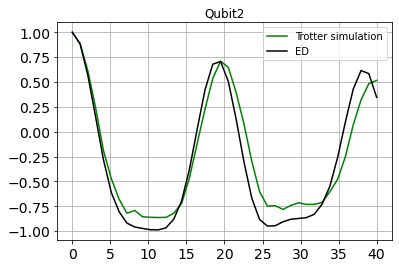

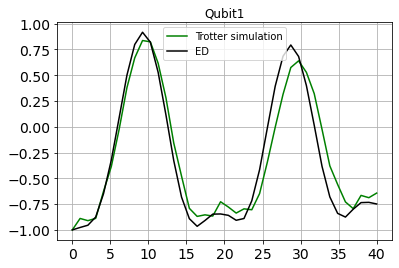

In [20]:
for i in range(L):
    
    t=np.linspace(0,T,NN)
    plt.title("Qubit"+str(L-i))
    #plt.plot(t,Sz_nomit[:,i],color='r',label='Without the mitigation')
    #plt.plot(t,Sz_mit[:,i],color='b',label='With the mitigation')
    plt.plot(t,Sz_sim[:,i],color='g',label='Trotter simulation')
    #plt.plot(t,Sz_mit_DD[:,i],color='y',label='With DD and mit')
    #plt.plot(t,Sz_mit_no_custom[:,i],color='m',label='Two Cnot gate with mit')
    plt.plot(t,Zi[i,:],color='k',label='ED')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.show()

In [21]:
Z_pi=0
Z_pi_sim=0
for i in range(L):
    Z_pi+=((-1)**(i))*Zi[i,:]
    Z_pi_sim+=((-1)**(i))*Sz_sim[:,i]

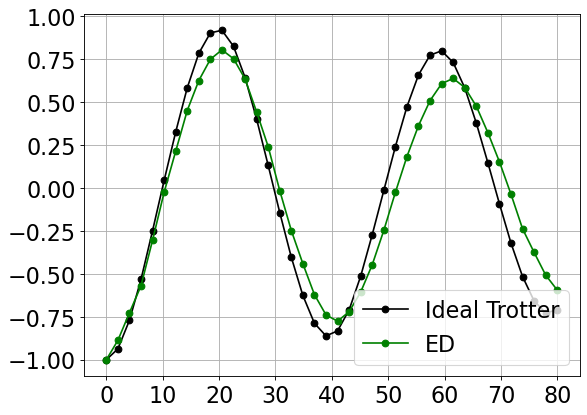

In [22]:
t=np.linspace(0,T*2,NN)
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(t,-Z_pi/L,'go-',color='k',label='Ideal Trotter')
plt.plot(t,-Z_pi_sim/L,'go-',color='g',label='ED')

plt.legend()
plt.grid()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize = 20)
plt.show()